In [103]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os,sys

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import mlflow
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime


import pickle #  To Read and Save model - Serialization


sys.path.append(os.path.abspath(os.path.join('..')))
import scripts
from scripts import util
from scripts import plots
from scripts.config import Config


sns.set_style("darkgrid")
%matplotlib inline

In [105]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
train_data.head()

C:\Users\ProgrammingOperative\AppData\Local\Temp\ipykernel_3488\1666470514.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('../data/train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


## 2.1 Preprocessing

In [107]:
# Converting Date feature into datetime object
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

In [109]:
store_data = pd.read_csv('../data/store.csv')

In [111]:
train_store = pd.merge(train_data, store_data, how = 'left', on = "Store")
test_store = pd.merge(test_data, store_data, how = 'left', on = "Store")

train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [113]:
# # add_date_features(train_store)
# for data in [train_store, test_store]:
#     data = util.add_month_year(data)
    
# store_data.head()

In [115]:
# add_date_features(train_store)
train_store = util.add_month_year(train_store)
test_store = util.add_month_year(test_store)

train_store.head()

D:\10 Academy\Week 3\Pharmaceutical-Sales-Prediction\scripts\util.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  new_df['WeekOfYear'] = df['Date'].dt.weekofyear
D:\10 Academy\Week 3\Pharmaceutical-Sales-Prediction\scripts\util.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  new_df['WeekOfYear'] = df['Date'].dt.weekofyear


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


#### Adding year, month and day - Feature Engineering

In [117]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [119]:
#Calculating null percentage in the train dataset
print(f"Train Null Percentage : {util.get_null_percentage(train_store)} %")

Train Null Percentage : 9.71 %


In [121]:
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
dtype: int64

In [123]:
# No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values
train_store['CompetitionDistance'].fillna(train_store['CompetitionDistance'].median(), inplace = True)

#### Replacing the NAN in competitioDistance since no clear pattern is observed and also there are few data points

In [125]:
train_store.fillna(0, inplace = True)
train_store.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
dtype: int64

#### Filling all the other missing numerical years with 0s

In [127]:
# train_store = train_store.set_index('Date', inplace=False)
# train_store.head(5)

In [129]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


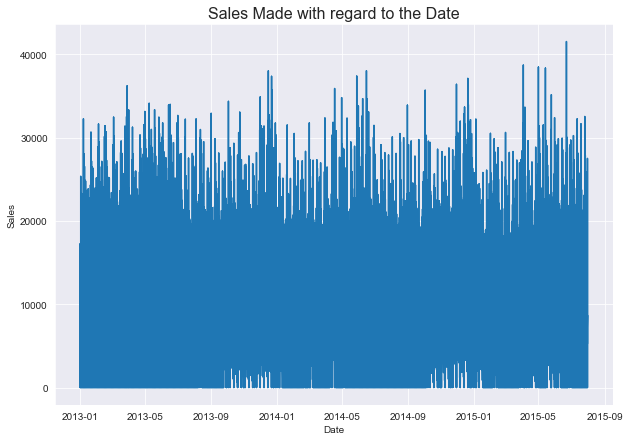

In [131]:

plt.figure(figsize=(10, 7))
plt.plot(train_store['Date'], train_store['Sales'])
plt.title("Sales Made with regard to the Date", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sales");

In [133]:
#Sorting a dataframe by date
train_store = train_store.sort_values(by='Date')

In [135]:
train_store = train_store.set_index('Date', inplace=False)
train_store.head(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,d,c,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,1
2013-01-01,379,2,0,0,0,0,a,1,d,a,...,0.0,0.0,0,0.0,0.0,0,2013,1,1,1
2013-01-01,378,2,0,0,0,0,a,1,a,c,...,8.0,2012.0,0,0.0,0.0,0,2013,1,1,1
2013-01-01,377,2,0,0,0,0,a,1,a,c,...,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2013,1,1,1
2013-01-01,376,2,0,0,0,0,a,1,a,a,...,8.0,2012.0,0,0.0,0.0,0,2013,1,1,1


In [137]:
### Label encoding
lb = LabelEncoder()
train_store['StoreType'] = lb.fit_transform(train_store['StoreType'])
train_store['Assortment'] = lb.fit_transform(train_store['Assortment'])
# train_store['PromoInterval'] = lb.fit_transform(train_store['PromoInterval'])

#Will come check performance if this column is dropped

train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,3,2,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,1
2013-01-01,379,2,0,0,0,0,a,1,3,0,...,0.0,0.0,0,0.0,0.0,0,2013,1,1,1
2013-01-01,378,2,0,0,0,0,a,1,0,2,...,8.0,2012.0,0,0.0,0.0,0,2013,1,1,1
2013-01-01,377,2,0,0,0,0,a,1,0,2,...,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2013,1,1,1
2013-01-01,376,2,0,0,0,0,a,1,0,0,...,8.0,2012.0,0,0.0,0.0,0,2013,1,1,1


#### Transforming the categorical variables into numerical features for machine learning

In [139]:
#Columns that will be used for modelling
columns = ['Sales','Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'Day', 'WeekOfYear','Month', 'Year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

feature_columns = ['Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'Day', 'WeekOfYear','Month', 'Year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

sample_size = 100000
sampled_df = (train_store[columns].sample(sample_size)).sort_values(by='Date')

In [141]:
## Separate Test and train files
train_x = sampled_df[feature_columns]
train_y = sampled_df[['Sales']]
train_x.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,Day,WeekOfYear,Month,Year,StoreType,Assortment,CompetitionDistance,Promo2
Date,,,,,,,,,,,,,
2013-01-01,285,2,0,0,1,1,1,1,2013,0,0,2410.0,0
2013-01-01,669,2,0,0,1,1,1,1,2013,3,0,17080.0,1
2013-01-01,387,2,0,0,1,1,1,1,2013,2,0,210.0,1
2013-01-01,386,2,0,0,1,1,1,1,2013,3,2,1460.0,1
2013-01-01,952,2,0,0,1,1,1,1,2013,3,2,6300.0,0


In [143]:
#Creating train_data for Deep Learning
train_dataset = train_store[columns].sort_values(by='Date')
train_dataset.head()
train_dataset.to_csv('../data/clean_train.csv', index=False)

In [145]:
# #Working on the test dataset


# test_data = pd.read_csv('../data/test.csv')
# test_store = pd.merge(test_data, store_data, how = 'left', on = "Store")
# test_store = util.add_month_year(test_store)
# test_store['CompetitionDistance'].fillna(train_store['CompetitionDistance'].median(), inplace = True)
# test_store.fillna(0, inplace = True)
# test_store = train_store.sort_values(by='Date')
# test_store = train_store.set_index('Date', inplace=False)
# test_store['StoreType'] = lb.fit_transform(train_store['StoreType'])
# test_store['Assortment'] = lb.fit_transform(train_store['Assortment'])



# test_dataset = (test_store[columns].sort_values(by='Date')
# test_dataset.to_csv('../data/clean_test.csv')

In [171]:
# Get sales date array
timesteps = train_x.index.to_numpy()
sales = train_y["Sales"].to_numpy()


timesteps[:10], sales[:10]


100000

In [177]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(sales)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], sales[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], sales[split_size:]



len(X_train), len(X_test), len(y_train), len(y_test)

(80000, 20000, 80000, 20000)

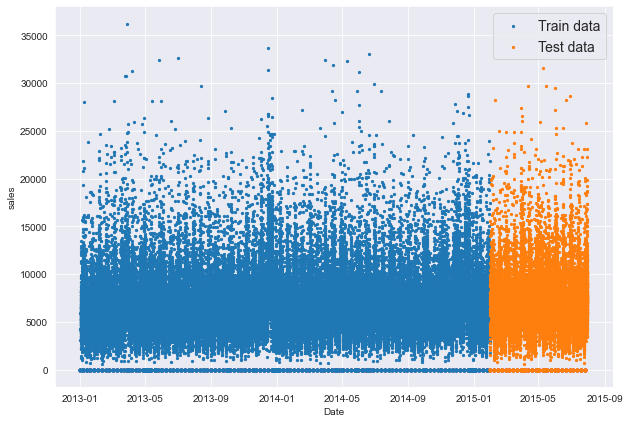

In [150]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("sales")
plt.legend(fontsize=14)
plt.show();

#### Create Train and Test set for our data in such a way that we engineer our test set to be in the future with respect to the training set

In [151]:
timesteps = train_x.to_numpy()
sales = train_y.to_numpy()




# Create train and test splits the right way for time series data
split_size = int(0.8 * len(sales)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], sales[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], sales[split_size:]



len(X_train), len(X_test), len(y_train), len(y_test)

(80000, 20000, 80000, 20000)

In [152]:
rf_reg = RandomForestRegressor(n_estimators = 100, max_depth=25, random_state=0)
rf_reg.fit(X_train, y_train)

C:\Users\ProgrammingOperative\AppData\Local\Temp\ipykernel_3488\283857576.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


RandomForestRegressor(max_depth=25, random_state=0)

In [153]:
score = rf_reg.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 90.16%


#### Good prediction score

In [154]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# X = x_scaler.fit_transform(train_x)
X = X_train
Y = y_scaler.fit_transform(y_train)

In [155]:
# Implementation of the pipeline

## Building models with sklearn pipelines

In [156]:
rfr = Pipeline(steps=[
    ('scaler1', MinMaxScaler()),
    ('rfr_regression', RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0))
])

lr = Pipeline(steps=[
    ('scaler2', MinMaxScaler()),
    ('lr_regression', LinearRegression())
])

dt = Pipeline(steps=[
    ('scaler3', MinMaxScaler()),
    ('dt_regretion', DecisionTreeRegressor(random_state = 0)  )
])

#### Create a pipeline where the data is first scaled before model training

In [157]:
rfr.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

C:\Users\ProgrammingOperative\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('scaler3', MinMaxScaler()),
                ('dt_regretion', DecisionTreeRegressor(random_state=0))])

In [158]:
rfr_score = rfr.score(X_test, y_test)
lr_score = lr.score(X_test, y_test)
dt_score = dt.score(X_test, y_test)

print(f"RandomForestRegretion prediction score {round(rfr_score * 100, 2)}%")
print(f"LinearRegression Prediction Score {round(lr_score * 100, 2)}%")
print(f"DecisionTree Prediction Score {round(dt_score * 100, 2)}%")

RandomForestRegretion prediction score 57.77%
LinearRegression Prediction Score 56.69%
DecisionTree Prediction Score 83.1%


## Choosing a loss function

In [159]:
rfr_prediction = rfr.predict(X_test)
lr_prediction = lr.predict(X_test)
dt_prediction = dt.predict(X_test)

rfr_rmse, rft_mae, _ = util.eval_metrics(y_test, rfr_prediction)
lr_rmse, lr_mae, _ = util.eval_metrics(y_test, lr_prediction)
dt_rmse, dt_mae, _ = util.eval_metrics(y_test, dt_prediction)


# print(f"Mean Absolute Loss : {round(mae * 100, 2)}%")
print(f"RandomForest Mean Square Loss : {rfr_rmse}")
print(f"Linear Mean Square Loss : {lr_rmse}")
print(f"DecisionTree Mean Square Loss : {dt_rmse }%")

RandomForest Mean Square Loss : 2519.6360641009387
Linear Mean Square Loss : 2551.727599655818
DecisionTree Mean Square Loss : 1594.0153820462335%


#### Choosing Mean Square Error as my loss function

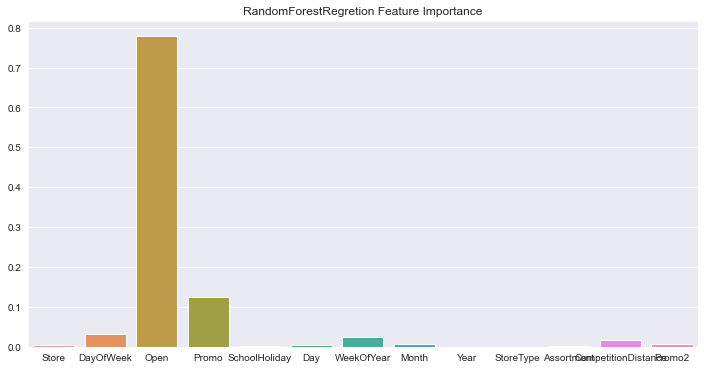

In [160]:
important_features = rfr[1].feature_importances_
plots.bar(feature_columns, important_features, 'RandomForestRegretion Feature Importance')

## Post Prediction analysis

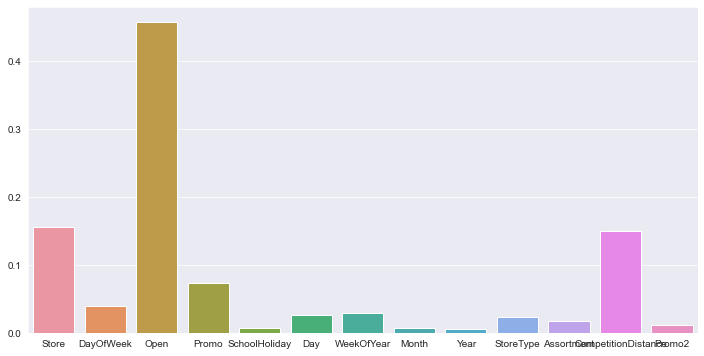

In [161]:
important_features = dt[1].feature_importances_
plots.bar(feature_columns, important_features)

#### Feature importance of our best perfoming algorithm

## Models Serialization

In [162]:
# now = datetime.now()
# current_time = now.strftime("%H:%M:%S")

reg_model_file_name = f'reg-{datetime.now().strftime("%H:%M:%S")}.pkl'
lr_model_file_name = f'lt-{datetime.now().strftime("%H:%M:%S")}.pkl'
dt_model_file_name = f'dt-{datetime.now().strftime("%H:%M:%S")}.pkl'

files_path = [reg_model_file_name, lr_model_file_name, dt_model_file_name]
models = [rfr, lr, dt]

print(dt_model_file_name)
print(lr_model_file_name)
print(reg_model_file_name)

dt-19:13:47.pkl
lt-19:13:47.pkl
reg-19:13:47.pkl


In [163]:
models_path = Config.MODELS_PATH
print(models_path)

..\models


In [164]:
path = models_path /"dt-09:48:19.pkl"
path

WindowsPath('../models/dt-09:48:19.pkl')

In [165]:
#Dump decision tree because it has better accuracy

model_path = '../models/' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + '.pkl'
pickle.dump(dt, open(model_path, 'wb'))

In [167]:
important_features = dt[1].feature_importances_
important_features[3]

0.0726040461061819

In [168]:
test

NameError: name 'array' is not defined

#### Serialization for easy tracking of  predictions from various models.